In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from datetime import datetime

In [2]:
plt.style.use('seaborn-v0_8')
plt.rcParams.update({'font.size': 8})

# Read dataset

In [3]:
path_processed = "processed/tuntidata_processed.csv"
path = "tuntidata.xlsx"

In [4]:
df_raw = pd.read_excel(path, header=0)

df_raw.head(10)

,Unnamed: 0,Ravintola,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,600 Chemicum,610 Physicum,620 Exactum,All groups
1,Date,249134,119756,75064,443954
2,2.1.2023,272,NaN,NaN,272
3,8,1,NaN,NaN,1
4,10,18,NaN,NaN,18
5,11,83,NaN,NaN,83
6,12,79,NaN,NaN,79
7,13,90,NaN,NaN,90
8,14,1,NaN,NaN,1
9,3.1.2023,327,NaN,NaN,327


In [5]:
df = df_raw\
    .rename(columns={'Unnamed: 0': 'datetime'})\
    .iloc[2:, :2]\
    .copy()

df.head()

,datetime,Ravintola
2,2.1.2023,272
3,8,1
4,10,18
5,11,83
6,12,79


# Pre-process

In [6]:
def parse_dt(s: str):
    components = [int(x) for x in s.split('.')]

    return datetime(day=components[0], month=components[1], year=components[2])

In [7]:
wastes = []

dt = None
for row in df.itertuples():
    try:
        hour = int(row.datetime)

        assert isinstance(dt, datetime)
        wastes.append({
            'date': dt,
            'weekday': dt.weekday(),
            'hour': hour,
            'datetime': dt.replace(hour=hour),
            'quantity': float(row.Ravintola)
        })
    except ValueError:
        dt = parse_dt(row.datetime)

In [8]:
df_waste = pd.DataFrame.from_records(wastes)

df_waste.head()

,date,weekday,hour,datetime,quantity
0,2023-01-02,0,8,2023-01-02 08:00:00,1.0
1,2023-01-02,0,10,2023-01-02 10:00:00,18.0
2,2023-01-02,0,11,2023-01-02 11:00:00,83.0
3,2023-01-02,0,12,2023-01-02 12:00:00,79.0
4,2023-01-02,0,13,2023-01-02 13:00:00,90.0


# Plots

<Axes: xlabel='hour', ylabel='quantity'>

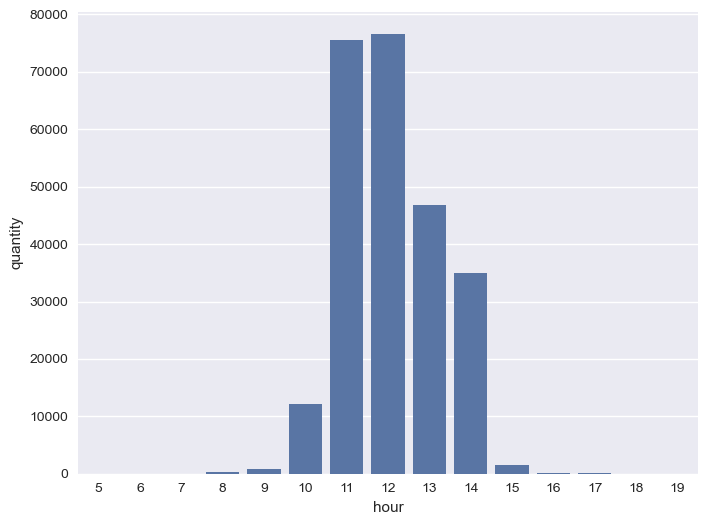

In [9]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

sns.barplot(df_waste.groupby('hour')['quantity'].sum(), ax=ax)

<Axes: xlabel='weekday', ylabel='quantity'>

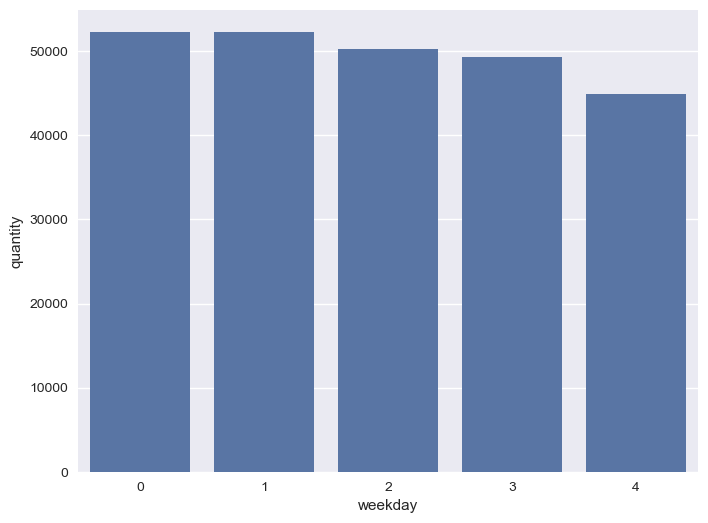

In [10]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

sns.barplot(df_waste.groupby('weekday')['quantity'].sum(), ax=ax)

## NaN investigation

In [11]:
df_na = df_waste[df_waste['quantity'].isna()]

df_na.head()

,date,weekday,hour,datetime,quantity
25,2023-01-09,0,7,2023-01-09 07:00:00,NaN
26,2023-01-09,0,8,2023-01-09 08:00:00,NaN
34,2023-01-09,0,16,2023-01-09 16:00:00,NaN
35,2023-01-10,1,8,2023-01-10 08:00:00,NaN
43,2023-01-11,2,7,2023-01-11 07:00:00,NaN


In [12]:
df_na['weekday'].unique()

array([0, 1, 2, 3, 4])

In [13]:
df_na['hour'].unique()

array([ 7,  8, 16,  9,  6,  5])

All missing values happen in non-peak hour

=> Can discard those rows

In [14]:
df_waste_processed = df_waste.dropna(axis=0, how='any')

print(len(df_waste))

df_waste.head()

3062


,date,weekday,hour,datetime,quantity
0,2023-01-02,0,8,2023-01-02 08:00:00,1.0
1,2023-01-02,0,10,2023-01-02 10:00:00,18.0
2,2023-01-02,0,11,2023-01-02 11:00:00,83.0
3,2023-01-02,0,12,2023-01-02 12:00:00,79.0
4,2023-01-02,0,13,2023-01-02 13:00:00,90.0


In [15]:
df_waste['date'].dt.year.unique()

array([2023, 2024], dtype=int32)

In [16]:
df_waste['date'].dt.month.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int32)

In [17]:
df_waste_processed = df_waste_processed[df_waste_processed['hour'].isin([10, 11, 12, 13, 14])]
df_waste_processed.head()

,date,weekday,hour,datetime,quantity
1,2023-01-02,0,10,2023-01-02 10:00:00,18.0
2,2023-01-02,0,11,2023-01-02 11:00:00,83.0
3,2023-01-02,0,12,2023-01-02 12:00:00,79.0
4,2023-01-02,0,13,2023-01-02 13:00:00,90.0
5,2023-01-02,0,14,2023-01-02 14:00:00,1.0


In [18]:
# df_waste_processed.to_csv(path_processed, index=False)

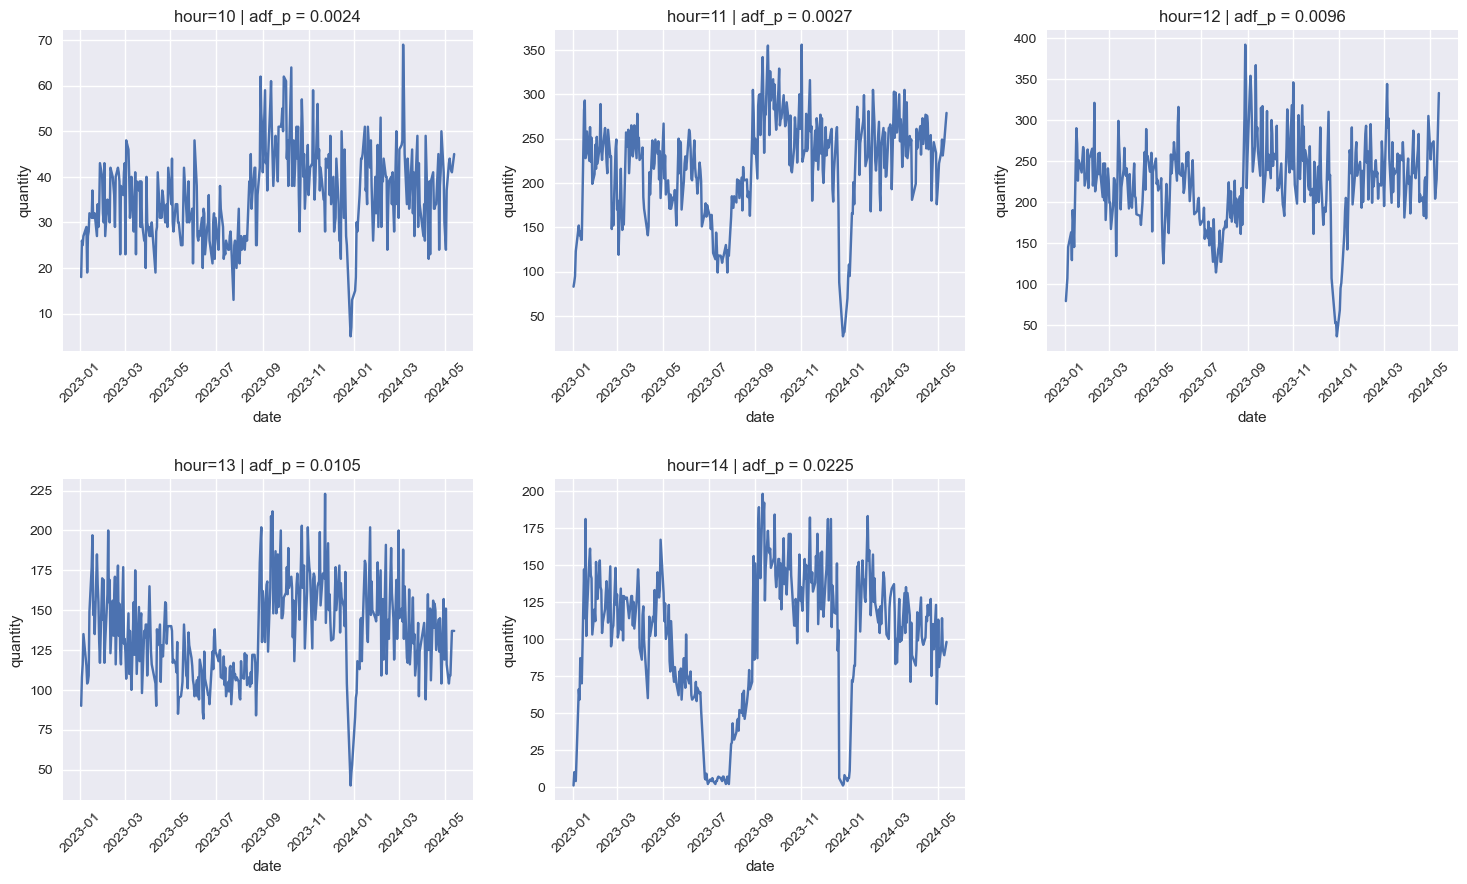

In [19]:
fig = plt.figure(figsize=(18, 10))
fig.subplots_adjust(wspace=0.2, hspace=0.4)

for i, hour in enumerate(df_waste_processed['hour'].unique()):
    df_hour = df_waste_processed[df_waste_processed['hour'] == hour]

    p_val = adfuller(df_hour['quantity'])[1]


    ax = fig.add_subplot(2, 3, i+1)
    sns.lineplot(df_hour, x='date', y='quantity', ax=ax)
    ax.set_title(f"hour={hour} | adf_p = {p_val:.4f}")
    ax.tick_params(axis='x', labelrotation = 45)

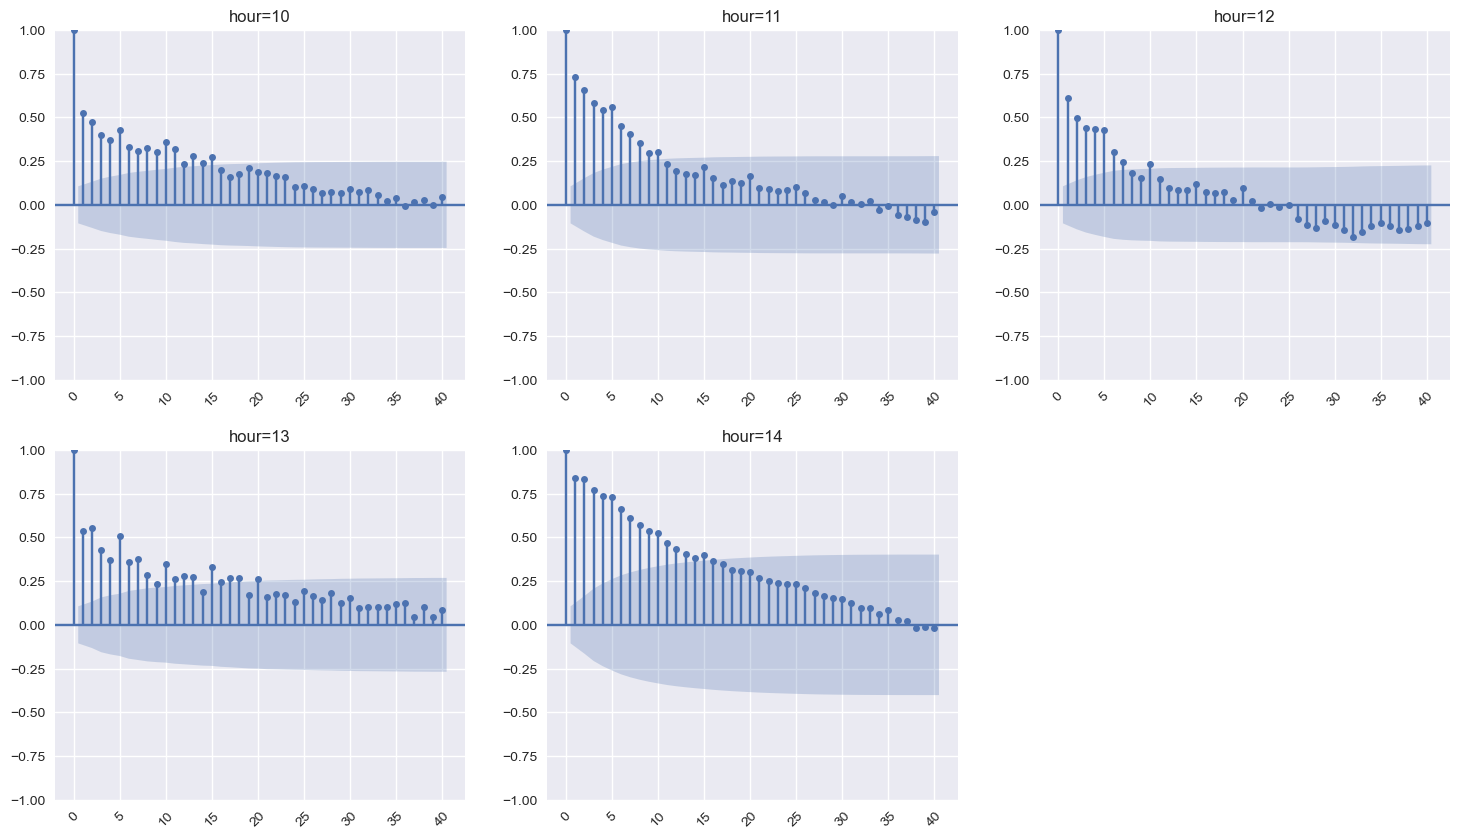

In [22]:
fig = plt.figure(figsize=(18, 10))
fig.subplots_adjust(wspace=0.2, hspace=0.2)

for i, hour in enumerate(df_waste_processed['hour'].unique()):
    df_hour = df_waste_processed[df_waste_processed['hour'] == hour]

    ax = fig.add_subplot(2, 3, i+1)
    sm.graphics.tsa.plot_acf(df_hour['quantity'].squeeze(), lags=40, ax=ax)
    ax.set_title(f"hour={hour}")
    ax.tick_params(axis='x', labelrotation = 45)



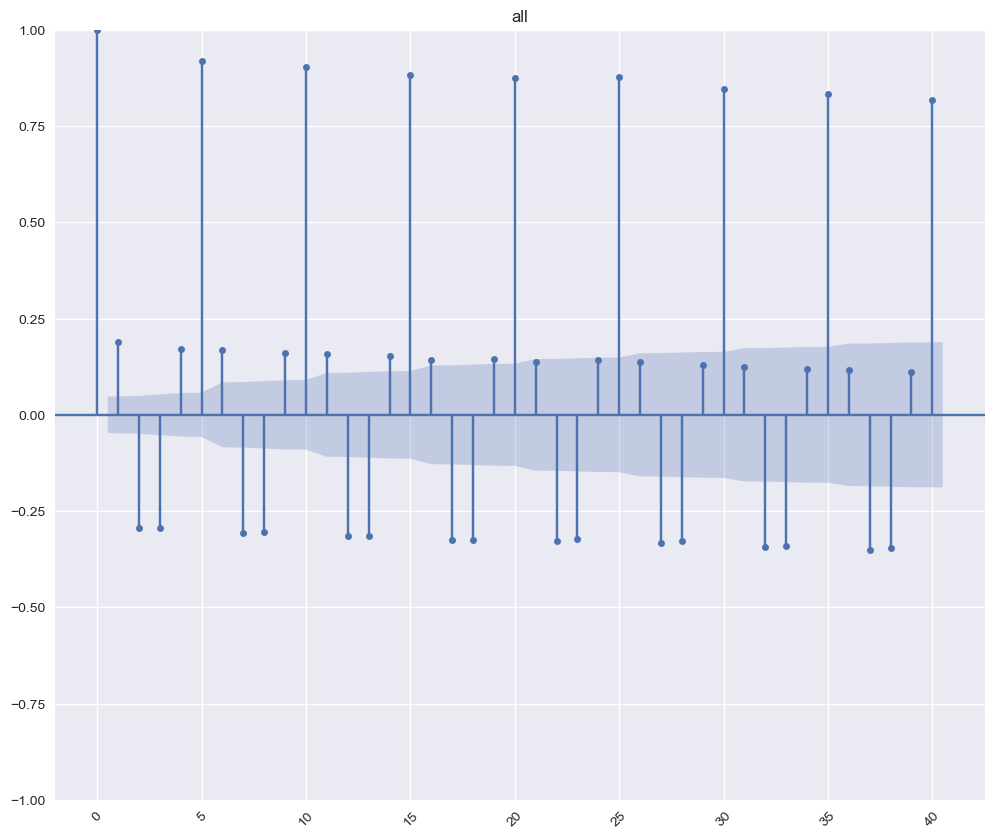

In [23]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111)

sm.graphics.tsa.plot_acf(df_waste_processed['quantity'].squeeze(), lags=40, ax=ax)
ax.set_title(f"all")
ax.tick_params(axis='x', labelrotation = 45)

In [25]:
df_waste_processed.head(10)

,date,weekday,hour,datetime,quantity
1,2023-01-02,0,10,2023-01-02 10:00:00,18.0
2,2023-01-02,0,11,2023-01-02 11:00:00,83.0
3,2023-01-02,0,12,2023-01-02 12:00:00,79.0
4,2023-01-02,0,13,2023-01-02 13:00:00,90.0
5,2023-01-02,0,14,2023-01-02 14:00:00,1.0
7,2023-01-03,1,10,2023-01-03 10:00:00,26.0
8,2023-01-03,1,11,2023-01-03 11:00:00,88.0
9,2023-01-03,1,12,2023-01-03 12:00:00,94.0
10,2023-01-03,1,13,2023-01-03 13:00:00,108.0
11,2023-01-03,1,14,2023-01-03 14:00:00,10.0


In [ ]:
for lag in [5, 10, 15, 20, 25]:
    break

df_waste_processed['']

In [29]:
df_waste_processed['quantity'].shift(5).head(20)

1       NaN
2       NaN
3       NaN
4       NaN
5       NaN
7      18.0
8      83.0
9      79.0
10     90.0
11      1.0
13     26.0
14     88.0
15     94.0
16    108.0
17     10.0
20     25.0
21     95.0
22    107.0
23    116.0
24      5.0
Name: quantity, dtype: float64